# 05 - SnakeCLEF - Preparation of the Mini and Validation Datasets

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd

from src.core import data


DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_cleaned_all.csv')
train_mini_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini_PROD.csv')
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_annotated.csv')

In [4]:
print(f'Train set length: {len(train_df):,d}')
print(f'Train set mini length: {len(train_mini_df):,d}')
print(f'Test set length: {len(valid_df):,d}')

Train set length: 377,228
Train set mini length: 70,208
Test set length: 23,673


In [5]:
classes = np.unique(train_df['binomial'])
classes_mini = np.unique(train_mini_df['binomial'])
classes_test = np.unique(valid_df['binomial'])
# classid2label = train_df.drop_duplicates(['class_id', 'binomial']).set_index('class_id')['binomial'].sort_index()

print(f'No classes in train set: {len(classes)}')
print(f'No classes in train set mini: {len(classes_mini)}')
print(f'No classes in test set: {len(classes_test)}')

No classes in train set: 770
No classes in train set mini: 768
No classes in test set: 694


In [6]:
np.isin(classes, classes_mini).sum(), np.isin(classes_mini, classes).sum()

(768, 768)

In [7]:
np.isin(classes, classes_test).sum(), np.isin(classes_test, classes).sum()

(693, 693)

## Train Set Mini

In [8]:
vc = train_mini_df['binomial'].value_counts()
# add missing classes
for label in classes[~np.isin(classes, classes_mini)]:
    vc.loc[label] = 0
vc

Pantherophis obsoletus       299
Storeria dekayi              298
Thamnophis sirtalis          298
Thamnophis proximus          297
Nerodia sipedon              295
                            ... 
Python curtus                  1
Acanthophis hawkei             1
Ramphotyphlops bipartitus      1
Morelia carinata               0
Oligodon trilineatus           0
Name: binomial, Length: 770, dtype: int64

In [9]:
# select training records not in mini dataset
_train_df = train_df[(train_df['subset'] == 'train') & ~train_df['UUID'].isin(train_mini_df['UUID'])]

# include records for classes to fill
classes_to_fill = 10 - vc[vc < 10]
rows_to_add = []
for label, count in classes_to_fill.items():
    # one exception - class that needs to be included into test data also
    if label == 'Achalinus formosanus':
        assert count == 1
        continue
    rows_to_add.append(_train_df[_train_df['binomial'] == label].sample(count))
mini_addition_df = pd.concat(rows_to_add, axis=0)
len(mini_addition_df)

232

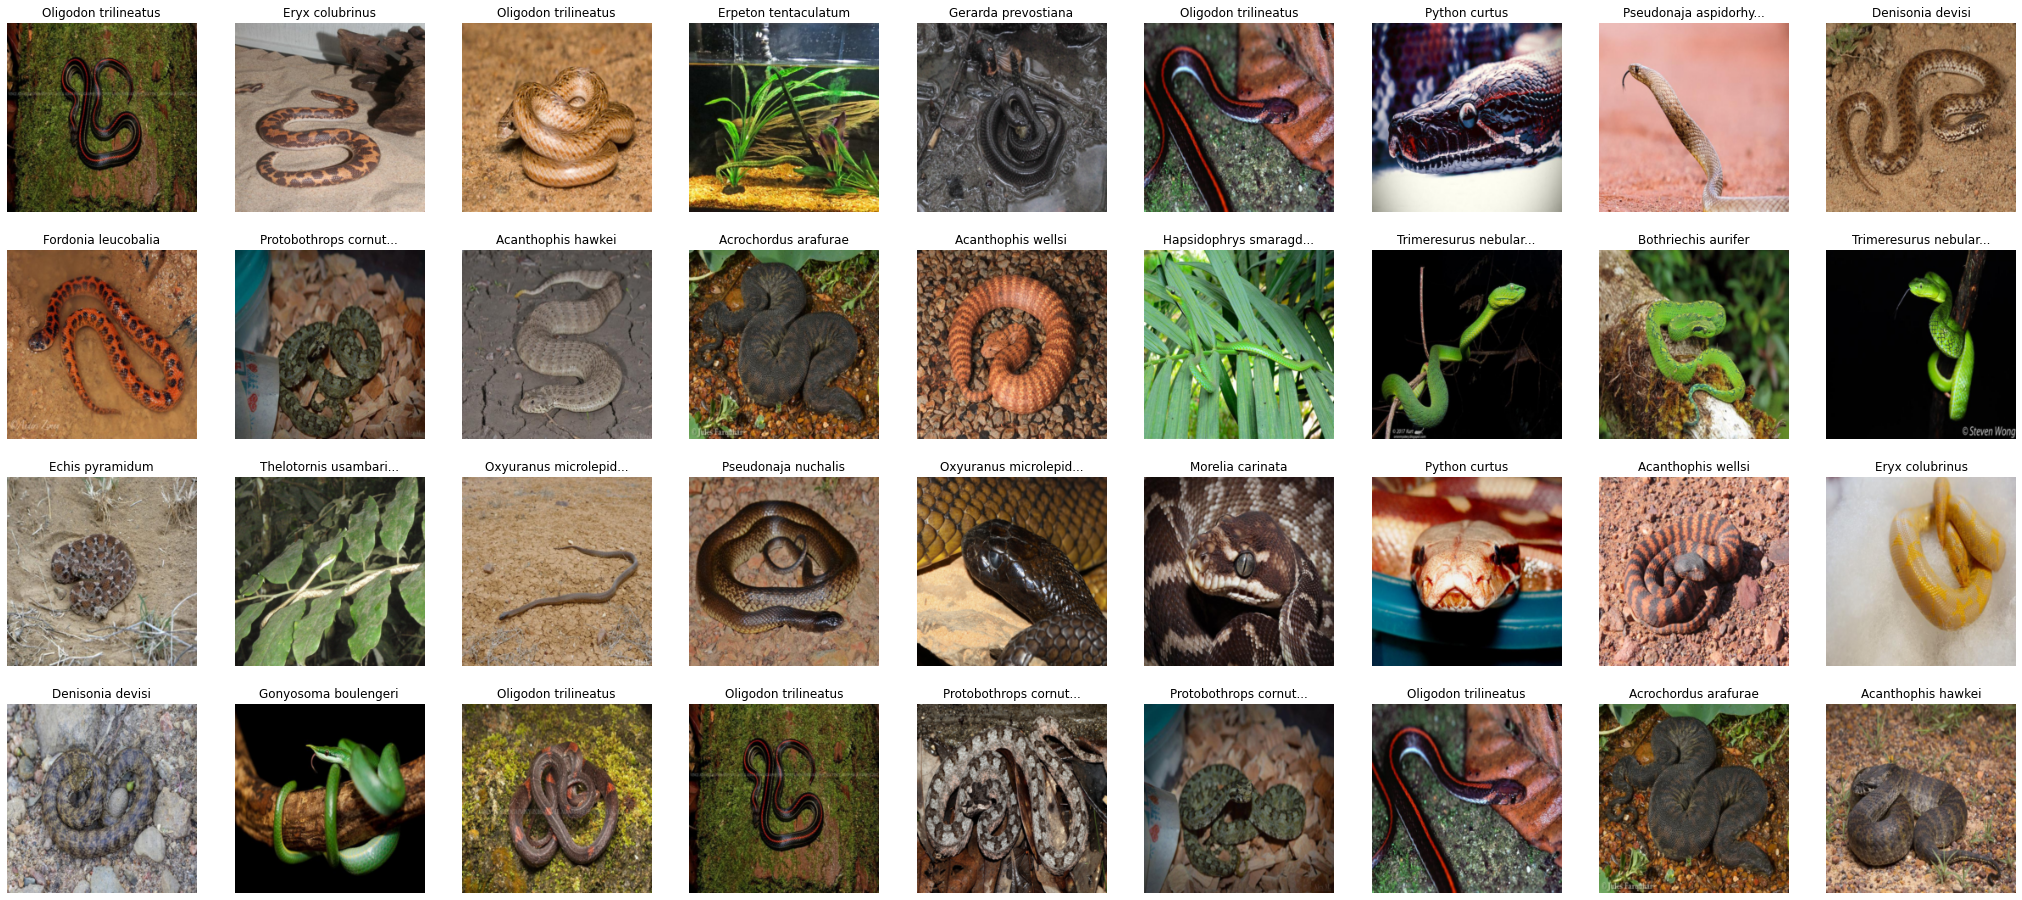

In [10]:
dataset = data.ImageDataset(
    mini_addition_df, img_path_col='image_path', label_col='binomial', transforms=None,
    path=DATA_DIR + 'train')

dataset.show_items(colsize=4, rowsize=4, ncols=9, nrows=4)

In [11]:
train_mini_df_new = pd.concat([train_mini_df, mini_addition_df], axis=0)
classes_mini_new = np.unique(train_mini_df_new['binomial'])
assert np.all(classes_mini_new == classes)
print(f'Train set mini length: {len(train_mini_df):,d}')
print(f'Train set mini new length: {len(train_mini_df_new):,d}')
print(f'No classes in train set mini: {len(classes_mini)}')
print(f'No classes in train set mini new: {len(classes_mini_new)}')

Train set mini length: 70,208
Train set mini new length: 70,440
No classes in train set mini: 768
No classes in train set mini new: 770


In [12]:
train_mini_df_new['binomial'].value_counts()

Pantherophis obsoletus     299
Storeria dekayi            298
Thamnophis sirtalis        298
Thamnophis proximus        297
Nerodia sipedon            295
                          ... 
Morelia viridis             10
Fordonia leucobalia         10
Python curtus               10
Trimeresurus sumatranus     10
Achalinus formosanus         9
Name: binomial, Length: 770, dtype: int64

In [13]:
train_mini_df_new['source'].value_counts()

inaturalist    59519
herpmapper     10692
flickr           229
Name: source, dtype: int64

In [14]:
train_mini_df_new['subset'].value_counts()

train    70440
Name: subset, dtype: int64

In [15]:
train_mini_df_new.to_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini.csv', index=False)
# train_mini_df_new = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini.csv')

## Test Set

In [16]:
# pre-process test dataset
valid_df['image_path'] = valid_df['file_path'].apply('test/{}'.format)
valid_df = valid_df.drop(columns=['file_path'])

In [17]:
testset = data.ImageDataset(
    valid_df, img_path_col='image_path', label_col='binomial', transforms=None,
    path=DATA_DIR + 'train')

['Echinanthera melanostigma']


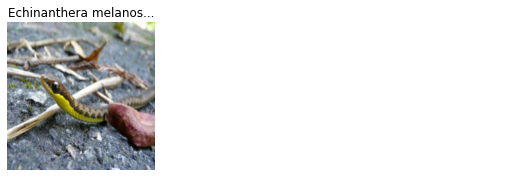

In [18]:
# remove extra classes
extra_classes = classes_test[~np.isin(classes_test, classes)]
print(extra_classes)

idx = valid_df[valid_df['binomial'].isin(extra_classes)].index
testset.show_items(idx)

valid_df = valid_df[~valid_df['binomial'].isin(extra_classes)]

In [19]:
vc = valid_df['binomial'].value_counts()
# add missing classes
for label in classes[~np.isin(classes, classes_test)]:
    vc.loc[label] = 0
vc

Thamnophis sirtalis            2073
Storeria dekayi                 896
Coluber constrictor             784
Pituophis catenifer             713
Nerodia sipedon                 594
                               ... 
Trimorphodon vilkinsonii          0
Vipera walser                     0
Xenochrophis flavipunctatus       0
Xenochrophis piscator             0
Xenopholis scalaris               0
Name: binomial, Length: 770, dtype: int64

In [20]:
train_mini_df_new = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini.csv')

# select training records not in mini dataset and test set
_train_df = train_df[~train_df['UUID'].isin(valid_df['UUID']) & 
                     ~train_df['UUID'].isin(train_mini_df_new['UUID'])]

# include records for classes to fill
classes_to_fill = 10 - vc[vc < 10]
rows_to_add = []
for label, count in classes_to_fill.items():
    _df = _train_df[_train_df['binomial'] == label]
    if count != min(count, len(_df)):
        print(f'{label}\tCount={count}, sample count={min(count, len(_df))}')
    rows_to_add.append(_df.sample(min(count, len(_df))))
test_addition_df = pd.concat(rows_to_add, axis=0)
len(test_addition_df)

Pseudelaphe phaescens	Count=4, sample count=3
Crotalus intermedius	Count=5, sample count=3
Geophis hoffmanni	Count=5, sample count=4
Porthidium yucatanicum	Count=5, sample count=4
Agkistrodon russeolus	Count=5, sample count=4
Hebius beddomei	Count=6, sample count=4
Dendrophidion bivittatus	Count=6, sample count=5
Pseudoleptodeira latifasciata	Count=6, sample count=5
Conopsis biserialis	Count=6, sample count=4
Mastigodryas danieli	Count=7, sample count=3
Micrurus distans	Count=7, sample count=6
Gloydius intermedius	Count=7, sample count=6
Gerarda prevostiana	Count=7, sample count=4
Symphimus mayae	Count=7, sample count=3
Rhynchocalamus melanocephalus	Count=7, sample count=2
Philodryas baroni	Count=8, sample count=2
Lycodon flavozonatus	Count=8, sample count=7
Lygophis lineatus	Count=8, sample count=4
Euprepiophis conspicillata	Count=8, sample count=6
Vipera transcaucasiana	Count=8, sample count=7
Ficimia streckeri	Count=8, sample count=5
Cubophis vudii	Count=8, sample count=5
Hemorrhois

2555

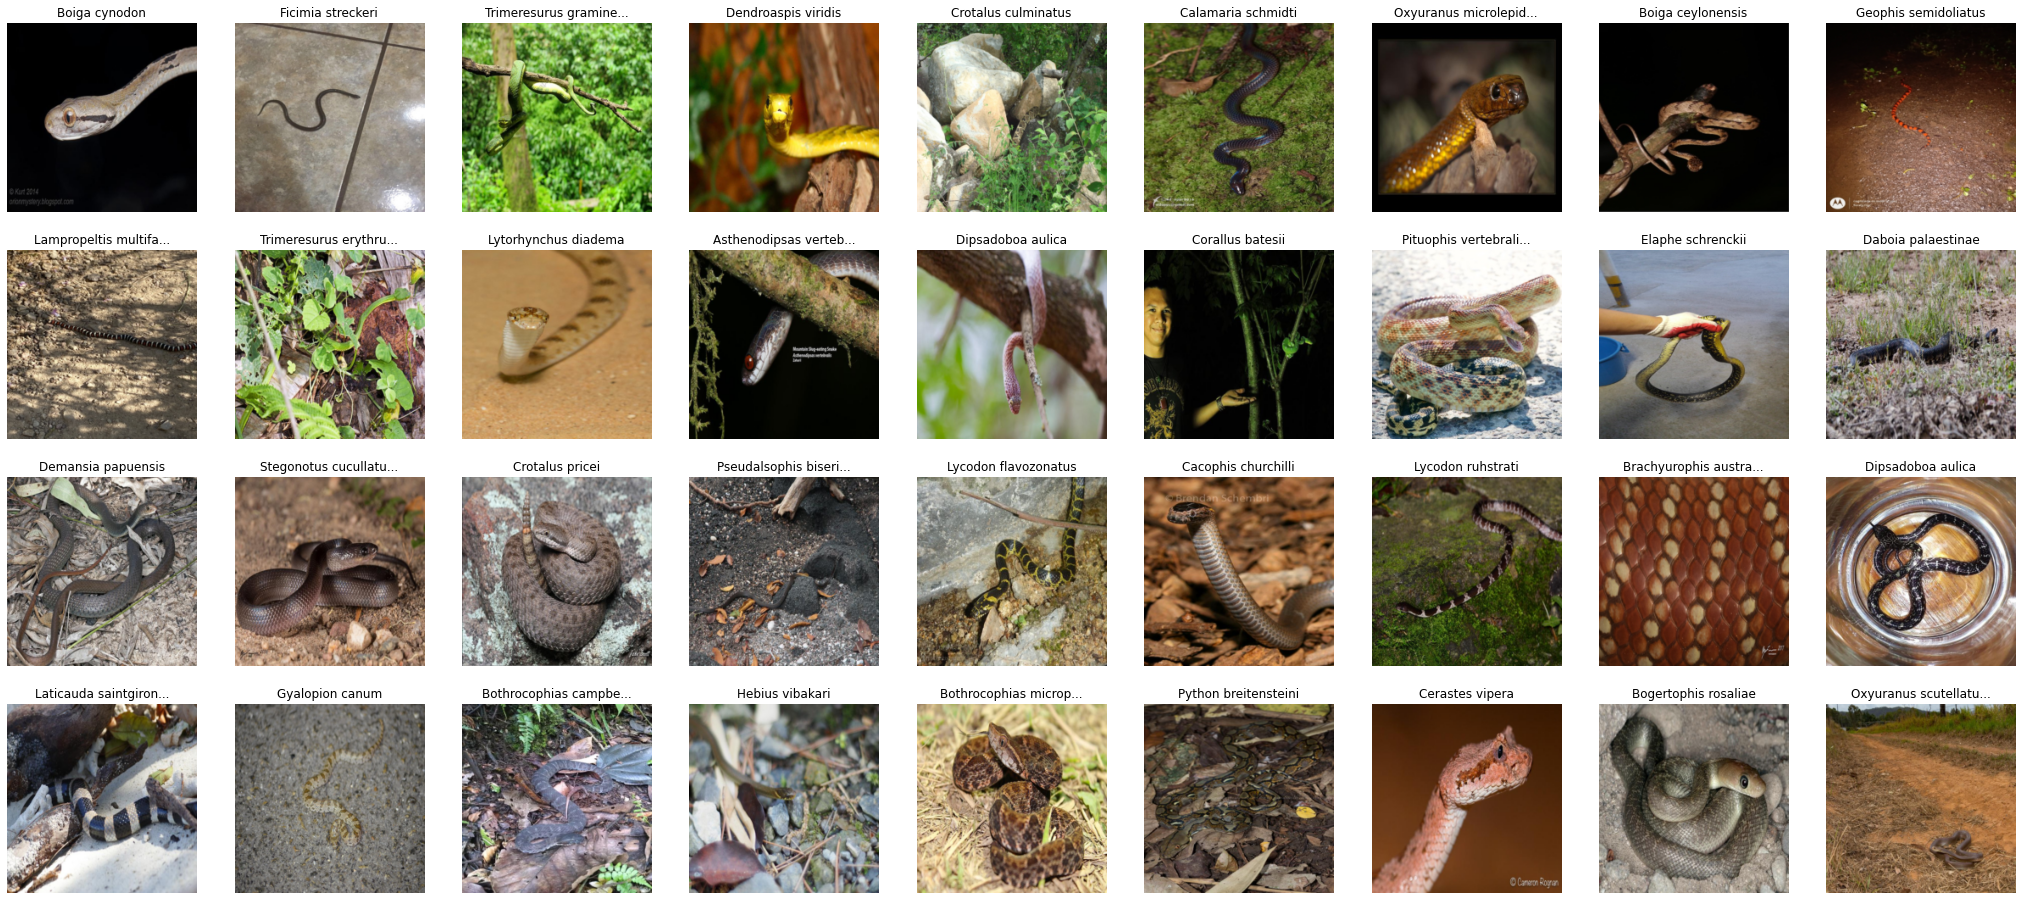

In [21]:
dataset = data.ImageDataset(
    test_addition_df, img_path_col='image_path', label_col='binomial', transforms=None,
    path=DATA_DIR + 'train')

dataset.show_items(colsize=4, rowsize=4, ncols=9, nrows=4)

In [22]:
valid_df_new = pd.concat([valid_df, test_addition_df], axis=0)
classes_test_new = np.unique(valid_df_new['binomial'])
# assert np.all(classes_test_new == classes)
print(f'Test set length: {len(valid_df):,d}')
print(f'Test set new length: {len(valid_df_new):,d}')
print(f'No classes in test set: {len(classes_test)}')
print(f'No classes in test set new: {len(classes_test_new)}')

Test set length: 23,672
Test set new length: 26,227
No classes in test set: 694
No classes in test set new: 770


In [23]:
valid_df_new['binomial'].value_counts()

Thamnophis sirtalis          2073
Storeria dekayi               896
Coluber constrictor           784
Pituophis catenifer           713
Nerodia sipedon               594
                             ... 
Rhadinaea taeniata              4
Philodryas baroni               4
Epictia goudotii                4
Thamnophis chrysocephalus       2
Achalinus formosanus            1
Name: binomial, Length: 770, dtype: int64

In [24]:
valid_df_new['source'].value_counts()

flickr         1905
inaturalist     531
herpmapper      119
Name: source, dtype: int64

In [25]:
valid_df_new['subset'].value_counts()

train    2302
val       253
Name: subset, dtype: int64

In [34]:
valid_df_new

country      continent                                  UUID  \
0         Costa Rica  South America  f8e1d62d-8c74-47ae-8db9-c4fb0d7a5672   
1         Costa Rica  South America  3068da5b-a72c-4398-8f70-afb2134cfa8d   
2         Costa Rica  South America  fcaece2a-90c7-4b07-80cf-f901e188dea8   
3         Costa Rica  South America  7aa20f9f-2f55-4f8f-93a2-a5a229df4232   
4         Costa Rica  South America  a2743578-8204-4f4d-b8e9-1ee65bad4925   
...              ...            ...                                   ...   
26222  French Guiana        unknown      32ed38bf6a9c4662a0629a1ca72e3397   
26223  French Guiana        unknown      4947df7e7e0d49f397eb51cf5ca00ffc   
26224           Peru  South America      9855b9b9c9bf46de9721bf8bc1ccf85e   
26225  French Guiana        unknown      e3b6b4d8bb184a99ac79eb764f5c7c71   
26226         Brazil  South America      5b5e9aba135947a5a1d7af167277db8e   

                     binomial        genus      family  class_id  \
0           Imantodes cenchoa    Imantodes  Colubridae       338   
1      Bothriechis schlegelii  Bothriechis   Viperidae        83   
2             Sibon annulatus        Sibon  Colubridae       635   
3           Oxybelis fulgidus     Oxybelis  Colubridae       509   
4             Sibon nebulatus        Sibon  Colubridae       637   
...                       ...          ...         ...       ...   
26222     Xenopholis scalaris   Xenopholis  Colubridae       766   
26223     Xenopholis scalaris   Xenopholis  Colubridae       766   
26224     Xenopholis scalaris   Xenopholis  Colubridae       766   
26225     Xenopholis scalaris   Xenopholis  Colubridae       766   
26226     Xenopholis scalaris   Xenopholis  Colubridae       766   

                                             image_path  
0         test/f8e1d62d-8c74-47ae-8db9-c4fb0d7a5672.jpg  
1         test/3068da5b-a72c-4398-8f70-afb2134cfa8d.jpg  
2         test/fcaece2a-90c7-4b07-80cf-f901e188dea8.jpg  
3         test/7aa20f9f-2f55-4f8f-93a2-a5a229df4232.jpg  
4         test/a2743578-8204-4f4d-b8e9-1ee65bad4925.jpg  
...                                                 ...  
26222       flickr/32ed38bf6a9c4662a0629a1ca72e3397.jpg  
26223       flickr/4947df7e7e0d49f397eb51cf5ca00ffc.jpg  
26224   herpmapper/9855b9b9c9bf46de9721bf8bc1ccf85e.jpg  
26225       flickr/e3b6b4d8bb184a99ac79eb764f5c7c71.jpg  
26226  inaturalist/5b5e9aba135947a5a1d7af167277db8e.jpg  

[26227 rows x 8 columns]

In [26]:
valid_df_new.drop(columns=['source', 'subset']).to_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv', index=False)
# valid_df_new = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')

## Train Set

In [27]:
uuids_to_remove = valid_df_new['UUID']
train_df_new = train_df[~train_df['UUID'].isin(uuids_to_remove)]
classes_new = np.unique(train_df_new['binomial'])

print(f'Train set length: {len(train_df):,d}')
print(f'Train set new length: {len(train_df_new):,d}')
print(f'No classes in train set: {len(classes)}')
print(f'No classes in train set new: {len(classes_new)}')

Train set length: 377,228
Train set new length: 374,673
No classes in train set: 770
No classes in train set new: 770


In [28]:
train_df_new.to_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_cleaned.csv', index=False)

## Validate Record Overlaps in New Datasets

In [29]:
train_df_ = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_cleaned.csv')
train_mini_df_ = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini.csv')
valid_df_ = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')

print(f'Train set length: {len(train_df_):,d}')
print(f'Train set mini length: {len(train_mini_df_):,d}')
print(f'Test set length: {len(valid_df_):,d}')

Train set length: 374,673
Train set mini length: 70,440
Test set length: 26,227


In [31]:
# assert train_df_['UUID'].isin(train_mini_df_['UUID']).sum() == 0
# assert train_mini_df_['UUID'].isin(train_df_['UUID']).sum() == 0

assert train_df_['UUID'].isin(valid_df_['UUID']).sum() == 0
assert valid_df_['UUID'].isin(train_df_['UUID']).sum() == 0

assert train_mini_df_['UUID'].isin(valid_df_['UUID']).sum() == 0
assert valid_df_['UUID'].isin(train_mini_df_['UUID']).sum() == 0

In [32]:
_df = pd.concat([
    train_df_['binomial'].value_counts(),
    train_mini_df_['binomial'].value_counts(),
    valid_df_['binomial'].value_counts()], axis=1)
_df.columns = ['train', 'train_mini', 'valid']
_df

train  train_mini  valid
Thamnophis sirtalis     22134         298   2073
Storeria dekayi         17520         298    896
Pantherophis obsoletus  12946         299    201
Crotalus atrox          12318         290    245
Nerodia sipedon         12157         295    594
...                       ...         ...    ...
Gerarda prevostiana        10          10      7
Hemorrhois ravergieri      10          10      5
Vipera transcaucasiana     10          10      9
Erpeton tentaculatum       10          10      8
Achalinus formosanus        9           9      1

[770 rows x 3 columns]

In [33]:
classes_ = np.unique(train_df_['binomial'])
classes_mini_ = np.unique(train_mini_df_['binomial'])
classes_test_ = np.unique(valid_df_['binomial'])
# classid2label = train_df.drop_duplicates(['class_id', 'binomial']).set_index('class_id')['binomial'].sort_index()

print(f'No classes in train set: {len(classes_)}')
print(f'No classes in train set mini: {len(classes_mini_)}')
print(f'No classes in test set: {len(classes_test_)}')
assert all(classes_ == classes_mini_)
assert all(classes_ == classes_test_)
assert all(classes_mini_ == classes_test_)

No classes in train set: 770
No classes in train set mini: 770
No classes in test set: 770
